# 0. Preliminaries

In [1]:
import json
import random
import os
from PIL import Image
from itertools import product
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter

from domain import SYM2PROG, Program, NULL_VALUE
import sys

In [2]:
symbol_images_dir = 'symbol_images/'
splits = ['train', 'val', 'test']
max_value_train = 100
max_value_test = 10000

min_num = 0
max_num = 10
num_list = list(map(str, range(min_num, max_num)))
nonzero_num_list = [x for x in num_list if x != '0']
op_list = ['+', '-', '*', '/']
lps = '('
rps = ')'

print(num_list)
print(op_list, lps, rps)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['+', '-', '*', '/'] ( )


In [3]:
def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

# 1. Split handwritten symbols

In [4]:
# split train and test set of math symbols
random.seed(777)
terminals = ['+', '-', 'times', 'div', '(', ')', '!'] + list(map(str, list(range(10)))) + ['alpha', 'beta', 'gamma', 'theta', 'phi'] + list('abcde')
sym_train_set = {}
sym_val_set = {}
sym_test_set = {}
for tok in terminals:
    imgs = os.listdir(symbol_images_dir + tok)
    random.shuffle(imgs)
    n_train = int(len(imgs) * 0.75)
    n_val = int(len(imgs) * 0.05)
    sym_train_set[tok] = sorted(imgs[:n_train])
    sym_val_set[tok] = sorted(imgs[n_train:n_train+n_val])
    sym_test_set[tok] = sorted(imgs[n_train+n_val:])
    print(tok, len(imgs))
json.dump(sym_train_set, open('sym_train.json', 'w'))
json.dump(sym_val_set, open('sym_val.json', 'w'))
json.dump(sym_test_set, open('sym_test.json', 'w'))

+ 5443
- 6022
times 600
div 157
( 3986
) 3978
! 224
0 1810
1 6327
2 6210
3 2469
4 1641
5 1008
6 812
7 753
8 731
9 742
alpha 383
beta 295
gamma 90
theta 543
phi 83
a 2724
b 1830
c 1194
d 1062
e 616


# 2. Generate expressions

In [5]:
random.seed(777)
class Iterator:
    def __init__(self, l, shuffle=True):
        if shuffle: 
            random.shuffle(l)
        self.list = l
        self.current = -1
        self.shuffle = shuffle
    
    def next(self):
        self.current += 1
        if self.current == len(self.list):
            self.current = 0
            if self.shuffle:
                random.shuffle(self.list)
        return self.list[self.current]

tok_convert = {'*': 'times', '/': 'div', 'a': 'alpha', 'b': 'beta', 'c': 'gamma', 'd': 'phi', 'e': 'theta'}
def generate_img_paths(tokens, sym_set):
    img_paths = []
    for tok in tokens:
        if tok in tok_convert:
            tok = tok_convert[tok]
        
        img_name = sym_set[tok].next()
        img_paths.append(os.path.join(tok, img_name))   
        
    return img_paths

split2sym = {}
for split in splits:
    sym_set = {k:Iterator(v) for k,v in json.load(open('sym_%s.json'%split)).items()}
    split2sym[split] = sym_set

In [6]:
class Node:
    def __init__(self, index, symbol, smt, prob=0.):
        self.index = index
        self.symbol = symbol
        self.smt = smt
        self.children = []
        self.sym_prob = prob
        self._res = None
        self._res_computed = False

    def res(self):
        if self._res_computed:
            return self._res

        self._res = self.smt(*self.inputs())
        if isinstance(self._res, int) and self._res > sys.maxsize:
            self._res = None
        self.prob = self.sym_prob + np.log(self.smt.likelihood) + sum([x.prob for x in self.children])
        self._res_computed = True
        return self._res

    def inputs(self):
        return [x.res() for x in self.children if x.res() is not NULL_VALUE]

class AST: # Abstract Syntax Tree
    def __init__(self, pt, semantics):
        self.pt = pt
        self.semantics = semantics

        nodes = [Node(i, s, semantics[s]) for i, s in enumerate(pt.sentence)]

        for node, h in zip(nodes, pt.head):
            if h == -1:
                self.root_node = node
                continue
            nodes[h].children.append(node)
        self.nodes = nodes

        self.root_node.res()
    
    def res(self): return self.root_node.res()
    
    def res_all(self): return [nd._res for nd in self.nodes]

In [7]:
op2precedence = {'+': 2, '-': 2, '*': 3, '/': 3, '!': 4}
op2arity = {'+': 2, '-': 2, '*': 2, '/': 2, '!': 1}

def parse_infix(expr):
    values = []
    operators = []
    
    head = [-1] * len(expr)
    for (i,sym) in enumerate(expr):
        if sym.isdigit():
            values.append(i)
        elif sym == lps:
            operators.append(i)
        elif sym == rps:
            while expr[operators[-1]] != lps:
                op = operators.pop()
                for _ in range(op2arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            i_lps = operators[-1]
            i_rps = i
            head[i_lps] = op
            head[i_rps] = op
            operators.pop()
        else:
            while len(operators) > 0 and expr[operators[-1]] != lps and \
                op2precedence[expr[operators[-1]]] >= op2precedence[sym]:
                op = operators.pop()
                for _ in range(op2arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            operators.append(i)

    while len(operators) > 0:
        op = operators.pop()
        for _ in range(op2arity[expr[op]]):
            head[values.pop()] = op
        values.append(op)

    root_op = values.pop()
    head[root_op] = -1
    assert len(values) == 0

    return head

def parse_prefix(expr):
    head = [-1] * len(expr)
    arity = [op2arity.get(x, 0) for x in expr]
    for i in range(len(expr)):
        if i == 0: 
            head[i] = -1
            continue
        for j in range(i-1, -1, -1):
            if arity[j] > 0:
                break
        head[i] = j
        arity[j] -= 1
        #print(i, head, arity)

    return head

def flatten(expr):
    if len(expr) == 1:
        return expr
    return [y for x in expr for y in flatten(x)]

def prefix2infix(prefix):
    prefix = list(prefix)
    values = []
    while len(prefix) > 0:
        sym = prefix.pop()
        if sym.isdigit():
            values.append([sym])
        else:
            arity = op2arity[sym]
            precedence = op2precedence[sym]
            
            left = values.pop()
            right = values.pop() if arity == 2 else []
            """
            add parenthesis when:
            (1) left is a compound expression and its operator's precedence < the current operator
            (2) right is a compound expression and its operator's precedence <= the current operator
            here we assume that the operator is left-associative.
            """
            if len(left) > 1 and op2precedence[left[1]] < precedence:
                left = [lps] + left + [rps]
            if len(right) > 1 and op2precedence[right[1]] <= precedence:
                right = [lps] + right + [rps]
                
            new_value = [left, sym, right]
            values.append(new_value)
    
    infix = ''.join(flatten(values.pop()))
    assert len(values) == 0
    return infix

from collections import namedtuple
Parse = namedtuple('Parse', 'sentence head')
def eval_expr(expr, head):
    ast = AST(Parse(expr, head), SYM2PROG)
    return ast.res(), ast.res_all()
    
def eval_expr_by_eval(expr):
    expr_for_eval = []
    for symbol in expr:
        if symbol == '!':
            expr_for_eval[-1] = 'math.factorial(' + expr_for_eval[-1] + ')'
        elif symbol == '/':
            expr_for_eval.append('//')
        else:
            expr_for_eval.append(symbol)
#     try:
#         res = eval("".join(expr_for_eval))
#     except OverflowError:
#         res = None
    res = eval("".join(expr_for_eval))
    return res



expr = '6*(5-2)'
head = parse_infix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

expr = '/+64-31'
head = parse_prefix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

expr = prefix2infix(expr)
head = parse_infix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

6*(5-2) (18, [6, 18, -1, 5, 3, 2, -1]) [1, -1, 4, 4, 1, 4, 4]
/+64-31 (5, [5, 10, 6, 4, 2, 3, 1]) [-1, 0, 1, 1, 0, 4, 4]
(6+4)/(3-1) (5, [-1, 6, 10, 4, -1, 5, -1, 3, 2, 1, -1]) [2, 2, 5, 2, 2, -1, 8, 8, 5, 8, 8]


In [8]:
def enumerate_expression(n_op):
    if n_op == 0:
        return [[x] for x in num_list]
    
    expressions = []
    
    arity = 1
    ops = [op for op in op_list if op2arity[op] == arity]
    inputs = enumerate_expression(n_op-1)
    expressions.extend(product(ops, inputs))
    
    arity = 2
    ops = [op for op in op_list if op2arity[op] == arity]
    inputs = []
    for i in range(n_op):
        input_1 = enumerate_expression(i)
        input_2 = enumerate_expression(n_op - 1 - i)
        inputs.extend(product(input_1, input_2))
    expressions.extend(product(ops, inputs))
    
    expressions = [flatten(x) for x in expressions]
    return expressions

def sample_expression(n_op, n_instances, min_value=0, max_value=float('inf'), non_zero_res=False):
    def sample(n_op):
        if n_op == 0:
            return [random.choice(num_list)]
        op = random.choice(op_list)
        if op2arity[op] == 1:
            return [op] + sample(n_op-1)
        else:
            i = random.randint(0, n_op-1)
            j = n_op - 1 - i
            return [op] + sample(i) + sample(j)
    
    expressions = []
    with tqdm(total=n_instances) as pbar:
        while len(expressions) < n_instances:
            expr = sample(n_op)
            if expr in expressions:
                continue
            head = parse_prefix(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                if non_zero_res and res == 0:
                    continue
                max_res = max([x for x in res_all if x is not None])
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
                    pbar.update(1)
    return expressions

def generate_expression(n_op, n_instances, min_value=0, max_value=float('inf'), non_zero_res=False):
    if n_op <= 2:
        expressions = []
        for expr in enumerate_expression(n_op):
            head = parse_prefix(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                if non_zero_res and res == 0:
                    continue
                max_res = max([x for x in res_all if x is not None])
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
    else:
        assert n_instances is not None
        expressions = sample_expression(n_op, n_instances, min_value, max_value, non_zero_res)
    random.shuffle(expressions)
    expressions = expressions[:n_instances]
    
    temp = []
    for expr in expressions:
        expr = prefix2infix(expr)
        head = parse_infix(expr)
        res, res_all = eval_expr(expr, head)
        if res is not None:
            temp.append((expr, head, res, res_all))
    
    return temp

In [9]:
expressions = generate_expression(2, 100000)
print(len(expressions))
print(len([x for x in expressions if x[2] != 0]))
print(len([x for x in expressions if x[2] == 0]))
print(expressions[:3])

29970
22261
7709
[('9+(2+5)', [1, -1, 4, 4, 1, 4, 4], 16, [9, 16, -1, 2, 7, 5, -1]), ('9+0-7', [1, 3, 1, -1, 3], 2, [9, 9, 0, 2, 7]), ('(3+3)*7', [2, 2, 5, 2, 2, -1, 5], 42, [-1, 3, 6, 3, -1, 42, 7])]


In [10]:
random.seed(12306)
max_op = 20
max_train_op = 10
n_train = 10000
n_test = 1000
n_val = 100
train_exprs = []
val_exprs = []
test_exprs = []

for n_op in range(max_op + 1):
    if n_op > max_train_op:
        n_train = 0
    expressions = generate_expression(n_op, n_train + n_test, max_value=max_value_train)
    
    if n_train > 0:
        train_exprs.append(expressions[:n_train])
    val_exprs.append(expressions[:min(n_val, n_train)] + expressions[n_train:n_train+n_val])
    test_exprs.append(expressions[:min(n_test, n_train)] + expressions[n_train:n_train+n_test])
    
    expressions = generate_expression(n_op, n_test, 
                          min_value=max_value_train+1, max_value=max_value_test, non_zero_res=True)
    val_exprs[-1].extend(expressions[:n_val])
    test_exprs[-1].extend(expressions)

    print(n_op, len(train_exprs[-1]) if n_train > 0 else 0, len(val_exprs[-1]), len(test_exprs[-1]))
    
split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])

0 10 10 10
1 390 100 390


 11%|█▏        | 1243/11000 [00:00<00:00, 12423.44it/s]

2 10000 300 2740


  9%|▉         | 1018/11000 [00:00<00:00, 10173.29it/s]

3 10000 300 3000


  8%|▊         | 835/11000 [00:00<00:01, 8346.80it/s]

4 10000 300 3000


  6%|▋         | 703/11000 [00:00<00:01, 7028.00it/s]

5 10000 300 3000


  5%|▌         | 592/11000 [00:00<00:01, 5918.09it/s]

6 10000 300 3000


  4%|▍         | 492/11000 [00:00<00:02, 4916.24it/s]

7 10000 300 3000


  5%|▌         | 579/11000 [00:00<00:01, 5777.70it/s]

8 10000 300 3000


  4%|▍         | 420/11000 [00:00<00:02, 4193.31it/s]

9 10000 300 3000


 33%|███▎      | 326/1000 [00:00<00:00, 3247.91it/s]

10 10000 300 3000


 62%|██████▏   | 623/1000 [00:00<00:00, 3144.43it/s]

11 0 200 2000


 23%|██▎       | 228/1000 [00:00<00:00, 2271.02it/s]

12 0 200 2000


 26%|██▋       | 263/1000 [00:00<00:00, 2615.55it/s]

13 0 200 2000


 40%|███▉      | 398/1000 [00:00<00:00, 2004.14it/s]

14 0 200 2000


 21%|██        | 207/1000 [00:00<00:00, 2058.76it/s]

15 0 200 2000


 16%|█▌        | 162/1000 [00:00<00:00, 1617.41it/s]

16 0 200 2000


 17%|█▋        | 170/1000 [00:00<00:00, 1659.13it/s]

17 0 200 2000


 14%|█▍        | 141/1000 [00:00<00:00, 1378.61it/s]

18 0 200 2000


 13%|█▎        | 130/1000 [00:00<00:00, 1296.72it/s]

19 0 200 2000


100%|██████████| 1000/1000 [00:02<00:00, 454.89it/s]


20 0 200 2000
[('train', 90400), ('val', 4810), ('test', 47140)]


In [11]:
split2dataset = {}
for split in splits:
    sym_set = split2sym[split]
    exprs = split2exprs[split]
    dataset = []
    idx = 0
    for n_op, expr_list in enumerate(exprs):
        if n_op == 0:
            n_instance = 100
        elif n_op == 1:
            n_instance = 10
        else:
            n_instance = 1
        
        if split == 'val':
            n_instance *= 0.1
        n_instance = int(math.ceil(n_instance))
        print(n_op, n_instance, len(expr_list) * n_instance)
        for e in expr_list:
            for _ in range(n_instance):
                img_paths = generate_img_paths(e[0], sym_set)
                sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                      'expr': e[0], 'head': e[1], 'res': e[2], 'res_all': e[3]}
                idx += 1
                dataset.append(sample)
    split2dataset[split] = dataset
    print(split, len(dataset))

0 100 1000
1 10 3900
2 1 10000
3 1 10000
4 1 10000
5 1 10000
6 1 10000
7 1 10000
8 1 10000
9 1 10000
10 1 10000
train 94900
0 10 100
1 1 100
2 1 300
3 1 300
4 1 300
5 1 300
6 1 300
7 1 300
8 1 300
9 1 300
10 1 300
11 1 200
12 1 200
13 1 200
14 1 200
15 1 200
16 1 200
17 1 200
18 1 200
19 1 200
20 1 200
val 4900
0 100 1000
1 10 3900
2 1 2740
3 1 3000
4 1 3000
5 1 3000
6 1 3000
7 1 3000
8 1 3000
9 1 3000
10 1 3000
11 1 2000
12 1 2000
13 1 2000
14 1 2000
15 1 2000
16 1 2000
17 1 2000
18 1 2000
19 1 2000
20 1 2000
test 51640


In [12]:
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
print(max_len_train)
for split in ['val', 'test']:
    dataset = split2dataset[split]
    for sample in dataset:
        expr = sample['expr']
        if expr in train_exprs:
            evaluation = 1
        elif len(expr) <= max_len_train:
            max_value = max([x for x in sample['res_all'] if x is not None])
            if max_value <= max_value_train:
                evaluation = 2
            else:
                evaluation = 3
        else:
            max_value = max([x for x in sample['res_all'] if x is not None])
            if max_value <= max_value_train:
                evaluation = 4
            else:
                evaluation = 5
        sample['eval'] = evaluation

39


In [13]:
for split in splits:
    json.dump(split2dataset[split], open('expr_%s.json'%split, 'w'))

# 3. Data analysis

In [14]:
split2dataset = {}
for split in splits:
    split2dataset[split] = json.load(open('expr_%s.json'%split))
    
split2symset = {}
for split in splits:
    split2symset[split] = json.load(open('sym_%s.json'%split))

[(0, 33.28), (1, 12.22), (2, 5.65), (3, 3.94), (4, 3.53), (5, 3.16), (6, 3.22), (7, 2.86), (8, 3.13), (9, 2.72), (10, 26.3), (101, 0.0)]
[(0, 21.1), (1, 11.35), (2, 4.16), (3, 3.18), (4, 2.41), (5, 2.24), (6, 2.51), (7, 2.14), (8, 2.12), (9, 2.35), (10, 20.06), (101, 26.37)]


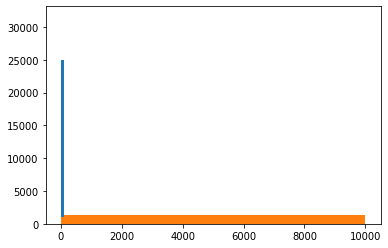

In [15]:
bins = list(range(10)) + [10, max_value_train+1, max_value_test]

dataset = split2dataset['train']
#res_counts = Counter([x['res'] for x in dataset])
#print(sorted(list(res_counts.items())))

n, _, _ = plt.hist([x['res'] for x in dataset], bins=bins)
n = n/n.sum()
print(list(zip(bins, np.round(n*100, 2))))
#plt.show()
#print(random.sample(dataset, k=3))

dataset = split2dataset['val']
res_counts = Counter([x['res'] for x in dataset])
#print(sorted(list(res_counts.items())))
n, _, _ = plt.hist([x['res'] for x in dataset], bins=bins)
n = n/n.sum()
print(list(zip(bins, np.round(n*100, 2))))
#print(random.sample(dataset, k=3))

train 94900 100
[('(', 220341), (')', 220341), ('*', 126914), ('+', 146620), ('-', 143098), ('/', 127268), ('0', 55404), ('1', 66914), ('2', 66806), ('3', 65678), ('4', 65620), ('5', 64550), ('6', 64027), ('7', 63527), ('8', 63480), ('9', 62794)]
[('(', 2989), (')', 2983), ('*', 450), ('+', 4082), ('-', 4516), ('/', 117), ('0', 1357), ('1', 4745), ('2', 4657), ('3', 1851), ('4', 1230), ('5', 756), ('6', 609), ('7', 564), ('8', 548), ('9', 556)]
(6+(0-3))/(7/(2+7))*((7-8)/(6/6)*8) [2, 2, 9, 5, 5, 2, 5, 5, 2, 19, 12, 12, 9, 15, 15, 12, 15, 15, 12, -1, 32, 23, 23, 26, 23, 23, 32, 29, 29, 26, 29, 29, 19, 32, 32] [-1, 6, 6, -1, 0, 0, 3, -1, -1, 6, -1, 7, 1, -1, 2, 9, 7, -1, -1, 0, -1, -1, 7, 0, 8, -1, 0, -1, 6, 1, 6, -1, 0, 8, -1] 0


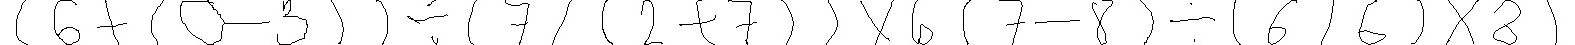

8-(7+7) [1, -1, 4, 4, 1, 4, 4] [8, 0, -1, 7, 14, 7, -1] 0


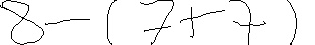

(6+3)*4-(4-(5-(9-1)/8)) [2, 2, 5, 2, 2, 7, 5, -1, 10, 10, 7, 13, 13, 10, 16, 16, 19, 16, 16, 13, 19, 13, 10] [-1, 6, 9, 3, -1, 36, 4, 36, -1, 4, 0, -1, 5, 4, -1, 9, 8, 1, -1, 1, 8, -1, -1] 36


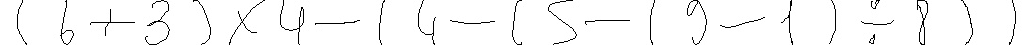

(0-9/8*(6*7))*(8*1+5) [2, 2, 13, 4, 6, 4, 2, 9, 9, 6, 9, 9, 2, -1, 18, 16, 18, 16, 13, 18, 18] [-1, 0, 0, 9, 2, 8, 84, -1, 6, 42, 7, -1, -1, 0, -1, 8, 8, 1, 13, 5, -1] 0


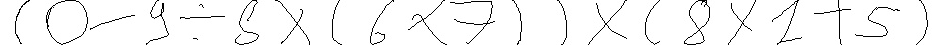

2-7*(1+9)-6*(4*0) [1, 9, 3, 1, 6, 6, 3, 6, 6, -1, 11, 9, 14, 14, 11, 14, 14] [2, 0, 7, 70, -1, 1, 10, 9, -1, 0, 6, 0, -1, 4, 0, 0, -1] 0


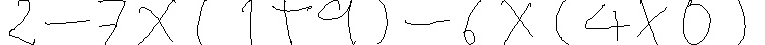

val 4900 9810
[('(', 21051), (')', 21051), ('*', 13321), ('+', 13108), ('-', 10935), ('/', 9936), ('0', 4023), ('1', 5254), ('2', 5234), ('3', 5301), ('4', 5313), ('5', 5328), ('6', 5374), ('7', 5348), ('8', 5473), ('9', 5552)]
[('(', 199), (')', 198), ('*', 30), ('+', 272), ('-', 301), ('/', 7), ('0', 90), ('1', 316), ('2', 310), ('3', 123), ('4', 82), ('5', 50), ('6', 40), ('7', 37), ('8', 36), ('9', 37)]
8*(3*6) [1, -1, 4, 4, 1, 4, 4] [8, 144, -1, 3, 18, 6, -1] 144


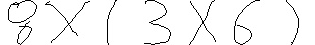

(1-(4-8-9))/(6+(3+5))/(2*8-(0-4)-2-8/1) [2, 2, 11, 7, 5, 7, 5, 2, 7, 7, 2, 21, 14, 14, 11, 17, 17, 14, 17, 17, 14, -1, 34, 24, 26, 24, 32, 29, 29, 26, 29, 29, 34, 32, 21, 36, 34, 36, 34] [-1, 1, 1, -1, 4, 0, 8, 0, 9, -1, -1, 1, -1, 6, 14, -1, 3, 8, 5, -1, -1, 1, -1, 2, 16, 8, 16, -1, 0, 0, 4, -1, 14, 2, 6, 8, 8, 1, -1] 1


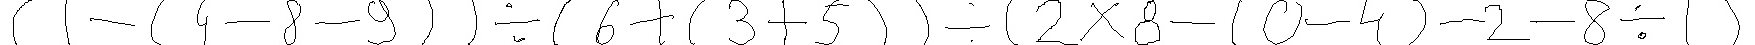

(0-8+9+(3+(7+2)/5))*(3*7+((6+9)*(9/(7*2))-3*1/9)) [6, 2, 4, 2, 6, 4, 19, 9, 9, 6, 12, 12, 15, 12, 12, 9, 15, 9, 6, -1, 24, 22, 24, 22, 19, 41, 28, 28, 31, 28, 28, 41, 34, 34, 31, 37, 37, 34, 37, 37, 34, 24, 43, 45, 43, 41, 45, 41, 24] [-1, 0, 0, 8, 9, 9, 14, -1, 3, 5, -1, 7, 9, 2, -1, 2, 5, -1, -1, 490, -1, 3, 21, 7, 35, -1, -1, 6, 15, 9, -1, 15, -1, 9, 1, -1, 7, 14, 2, -1, -1, 14, 3, 3, 1, 1, 9, -1, -1] 490


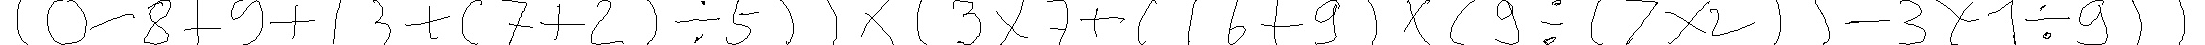

(9/1+(9-2+1*0+1)-6)*((8+3)*(3/9)+(9-0))+(4-8-5+(1+2-0)) [16, 2, 4, 2, 16, 13, 7, 9, 7, 13, 11, 9, 11, 4, 13, 13, 19, 16, 16, 39, 32, 23, 23, 26, 23, 23, 32, 29, 29, 26, 29, 29, 19, 35, 35, 32, 35, 35, 32, -1, 46, 42, 44, 42, 46, 44, 39, 51, 49, 51, 49, 46, 51, 51, 46] [-1, 9, 9, 1, 17, -1, 9, 7, 2, 7, 1, 0, 0, 8, 1, -1, 11, 6, -1, 220, -1, -1, 8, 11, 3, -1, 11, -1, 3, 1, 9, -1, 20, -1, 9, 9, 0, -1, -1, 223, -1, 4, 0, 8, 0, 5, 3, -1, 1, 3, 2, 3, 0, -1, -1] 223


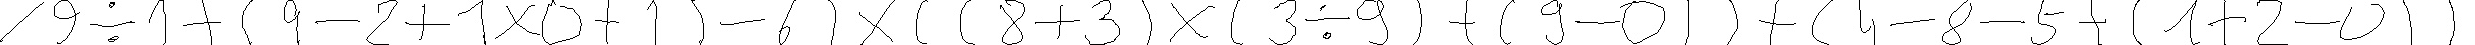

(3/2-0/3)/((2*9-2-2)*(9/(8*3))) [4, 2, 4, 2, 9, 6, 4, 6, 4, -1, 20, 17, 13, 15, 13, 17, 15, 20, 17, 17, 9, 23, 23, 20, 26, 26, 23, 26, 26, 23, 20] [-1, 3, 2, 2, 2, 0, 0, 3, -1, 1, -1, -1, 2, 18, 9, 16, 2, 14, 2, -1, 14, -1, 9, 1, -1, 8, 24, 3, -1, -1, -1] 1


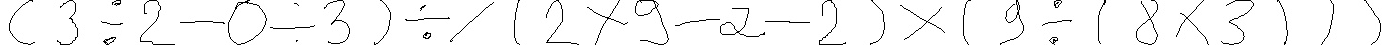

test 51640 9984
[('(', 210401), (')', 210401), ('*', 133514), ('+', 132811), ('-', 109667), ('/', 99388), ('0', 40399), ('1', 52109), ('2', 52800), ('3', 53594), ('4', 53851), ('5', 53906), ('6', 54204), ('7', 54710), ('8', 55464), ('9', 55983)]
[('(', 798), (')', 797), ('*', 120), ('+', 1089), ('-', 1205), ('/', 33), ('0', 363), ('1', 1266), ('2', 1243), ('3', 495), ('4', 329), ('5', 202), ('6', 163), ('7', 152), ('8', 147), ('9', 149)]
4/(1-(1*0+5)+(5+3)*9)+(3-2*((8+8-(5+0))*(8/1*4))-(3-1)-0)/9 [1, 21, 12, 4, 12, 9, 7, 9, 7, 4, 9, 9, 1, 15, 15, 18, 15, 15, 12, 18, 12, -1, 54, 24, 48, 26, 24, 39, 32, 30, 32, 30, 39, 35, 35, 32, 35, 35, 32, 26, 44, 42, 44, 42, 39, 44, 44, 39, 54, 51, 51, 48, 51, 51, 57, 54, 54, 21, 57] [4, 1, -1, 1, 0, -1, 1, 0, 0, 5, 5, -1, 72, -1, 5, 8, 3, -1, 72, 9, -1, 1, -1, 3, 0, 2, 704, -1, -1, 8, 16, 8, 11, -1, 5, 5, 0, -1, -1, 352, -1, 8, 8, 1, 32, 4, -1, -1, 0, -1, 3, 2, 1, -1, 0, 0, -1, 0, 9] 1


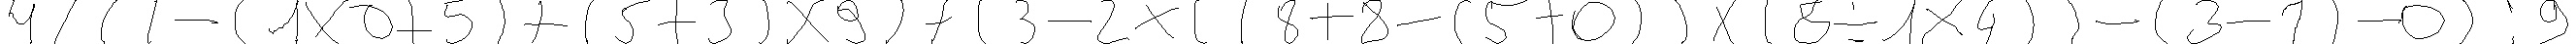

8/1+(5*7+2)*8 [1, 3, 1, -1, 8, 6, 8, 6, 11, 8, 8, 3, 11] [8, 8, 1, 304, -1, 5, 35, 7, 37, 2, -1, 296, 8] 304


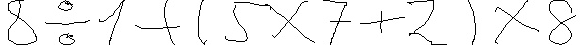

7*5*4+3 [1, 3, 1, 5, 3, -1, 5] [7, 35, 5, 140, 4, 143, 3] 143


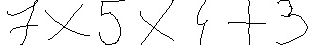

(2-(5+(6+3))+((4/(5-2)*8-9)/8-(5-9)))*(0*2*(4-(1+4)-(5-9-7))) [12, 2, 12, 5, 5, 2, 8, 8, 5, 8, 8, 5, 37, 29, 24, 16, 22, 19, 19, 16, 19, 19, 24, 22, 27, 24, 24, 29, 27, 12, 32, 32, 29, 32, 32, 29, 12, -1, 42, 40, 42, 40, 37, 51, 45, 51, 48, 48, 45, 48, 48, 42, 56, 54, 56, 54, 51, 56, 56, 51, 42] [-1, 2, 0, -1, 5, 14, -1, 6, 9, 3, -1, -1, 1, -1, -1, 4, 2, -1, 5, 3, 2, -1, 16, 8, 7, 9, -1, 1, 8, 1, -1, 5, 0, 9, -1, -1, -1, 0, -1, 0, 0, 2, 0, -1, 4, 0, -1, 1, 5, 4, -1, 0, -1, 5, 0, 9, 0, 7, -1, -1, -1] 0


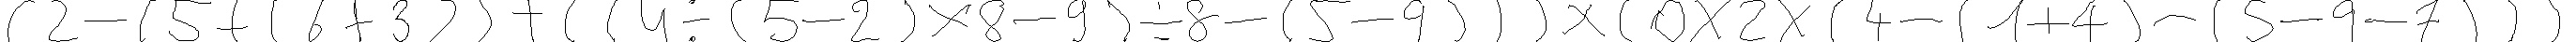

(8+4/(3*6))*6 [2, 2, 11, 4, 2, 7, 7, 4, 7, 7, 2, -1, 11] [-1, 8, 9, 4, 1, -1, 3, 18, 6, -1, -1, 54, 6] 54


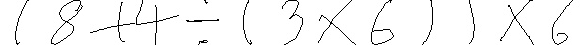

In [16]:
# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    all_symbols = [(x, y) for sample in dataset for x, y in zip(sample['img_paths'], sample['expr'])]
    print(sorted(Counter([x[1] for x in all_symbols]).items()))
    print(sorted(Counter([x[1] for x in set(all_symbols)]).items()))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
        display(img)

In [17]:
counts = sorted(Counter([x['eval'] for x in split2dataset['test']]).items())
total_count = sum([c for _, c in counts])
counts = [(k, round(v/total_count*100, 2)) for k, v in counts]
print(counts)
print(list({x['expr'] for x in split2dataset['test'] if x['eval'] == 3})[:10])
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
print(max_len_train)

[(1, 26.92), (2, 23.13), (3, 22.53), (4, 13.66), (5, 13.76)]
['1*(5+5)*8/1*(7+(2+0*2))', '(9*1+7/(9*3*2))*(4+(2+5))', '2*((9+3-0)/(5/4)*9)', '(2*2+2)*((1-6)*(2-6*7)+(6*7-(8+9)))', '(7+(3+4*8))*3/6-4+1*1*(8/5)', '8*5*9-0+8', '7+6/8+2*((0+7)*9)', '6*9/3*8', '(5+3+0+0/((5/5+6)*7*4))/6', '4*7*4']
39


(45, 45)


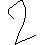

3+4*2 = 11


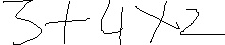

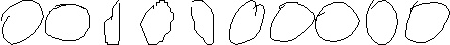

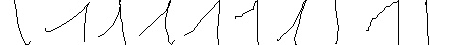

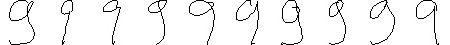

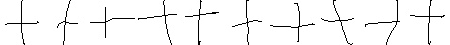

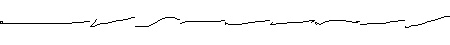

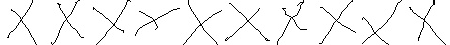

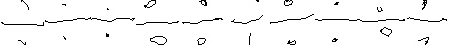

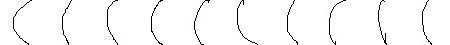

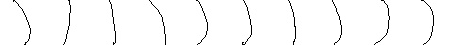

In [18]:
img = Image.open(symbol_images_dir + '2/2_849.jpg')
print(img.size)
display(img)

expr = '3+4*2'
img_paths = generate_img_paths(expr, sym_set=split2sym['train'])
img = render_img(img_paths)
print(expr,'=', eval(expr))
display(img)

for sym in '019+-*/()':
    expr = sym*10
    img_paths = generate_img_paths(expr, sym_set=split2sym['train'])
    img = render_img(img_paths)
    display(img)


In [19]:
def compute_depth(expr):
    depth = 0
    max_depth = 0
    for x in expr:
        if x == lps:
            c = 1
        elif x == rps:
            c = -1
        else:
            c = 0
        depth += c
        if depth > max_depth:
            max_depth = depth
    return max_depth

print(compute_depth('1*2*(1+2*((3+4)+(3-1))'))
ps_depths = [compute_depth(x['expr']) for x in split2dataset['train']]
print(Counter(ps_depths))

ps_depths = [compute_depth(x['expr']) for x in split2dataset['val']]
print(Counter(ps_depths))

3
Counter({2: 33269, 1: 32199, 0: 13381, 3: 13379, 4: 2419, 5: 240, 6: 12, 7: 1})
Counter({2: 1427, 3: 1255, 1: 1009, 4: 581, 0: 418, 5: 182, 6: 24, 7: 3, 8: 1})


(3/(7*9)*9+5)/(7/6)*(7*(0/(8*7))) [10, 2, 8, 5, 5, 2, 5, 5, 10, 8, 13, 10, 10, 19, 16, 16, 13, 16, 16, -1, 22, 22, 19, 25, 25, 22, 28, 28, 25, 28, 28, 25, 22] [-1, 3, 1, -1, 7, 63, 9, -1, 9, 9, 14, 5, -1, 7, -1, 7, 2, 6, -1, 0, -1, 7, 0, -1, 0, 0, -1, 8, 56, 7, -1, -1, -1] 0


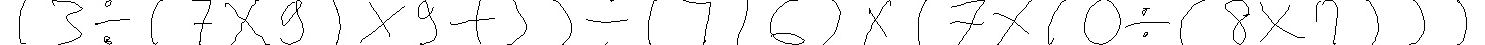

(7+1-(4+2)/(6*(0+2)))*(3/(7/2))+0 [4, 2, 4, 2, 21, 7, 7, 10, 7, 7, 4, 13, 13, 10, 16, 16, 13, 16, 16, 13, 4, 31, 24, 24, 21, 27, 27, 24, 27, 27, 24, -1, 31] [-1, 7, 8, 1, 7, -1, 4, 6, 2, -1, 1, -1, 6, 12, -1, 0, 2, 2, -1, -1, -1, 7, -1, 3, 1, -1, 7, 4, 2, -1, -1, 7, 0] 7


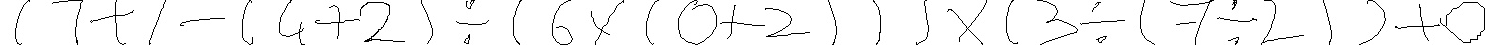

2-0/(4-(3-8))*(1+4)+7/(7+9) [1, 19, 3, 13, 6, 6, 3, 9, 9, 6, 9, 9, 6, 1, 16, 16, 13, 16, 16, -1, 21, 19, 24, 24, 21, 24, 24] [2, 2, 0, 0, -1, 4, 4, -1, 3, 0, 8, -1, -1, 0, -1, 1, 5, 4, -1, 3, 7, 1, -1, 7, 16, 9, -1] 3


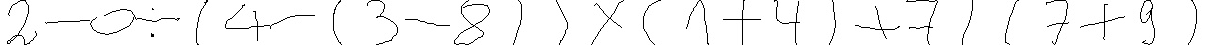

(7+9-6)*(2-(8-3))-(8+1)*6 [4, 2, 4, 2, 7, 4, 4, 17, 10, 10, 7, 13, 13, 10, 13, 13, 10, -1, 20, 20, 23, 20, 20, 17, 23] [-1, 7, 16, 9, 10, 6, -1, 0, -1, 2, 0, -1, 8, 5, 3, -1, -1, 0, -1, 8, 9, 1, -1, 54, 6] 0


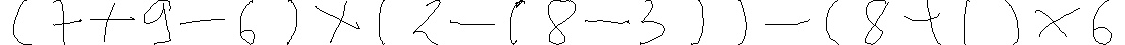

2*8+(1-4+(3+(3-0))) [1, 3, 1, -1, 8, 6, 8, 6, 3, 11, 11, 8, 14, 14, 11, 14, 14, 11, 8] [2, 16, 8, 22, -1, 1, 0, 4, 6, -1, 3, 6, -1, 3, 3, 0, -1, -1, -1] 22


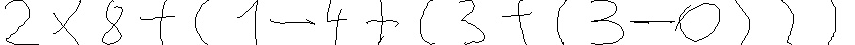

8*8-3/6+(4/3*2+5) [1, 3, 1, 7, 5, 3, 5, -1, 14, 10, 12, 10, 14, 12, 7, 14, 14] [8, 64, 8, 63, 3, 1, 6, 72, -1, 4, 2, 3, 4, 2, 9, 5, -1] 72


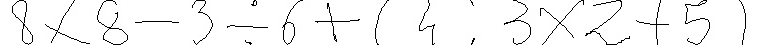

3+8 [1, -1, 1] [3, 11, 8] 11


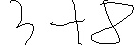

5*(4*0-(4-2*4)/2)/(3*4-4+4) [1, 17, 6, 4, 6, 4, 1, 9, 9, 14, 11, 9, 11, 9, 6, 14, 6, -1, 24, 20, 22, 20, 24, 22, 17, 24, 24] [5, 0, -1, 4, 0, 0, 0, -1, 4, 0, 2, 8, 4, -1, 0, 2, -1, 0, -1, 3, 12, 4, 8, 4, 12, 4, -1] 0


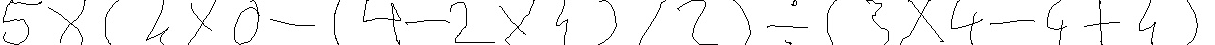

6*0-(2+4+4*9-1-(9+9)/(5/2)) [1, 3, 1, -1, 14, 6, 8, 6, 12, 10, 8, 10, 14, 12, 3, 17, 17, 20, 17, 17, 14, 23, 23, 20, 23, 23, 14] [6, 0, 0, 0, -1, 2, 6, 4, 42, 4, 36, 9, 41, 1, 35, -1, 9, 18, 9, -1, 6, -1, 5, 3, 2, -1, -1] 0


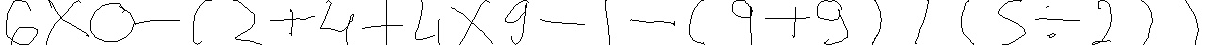

9-1+(8/(9/4)+6-0+8)-0/1+8 [1, 3, 1, 19, 16, 6, 12, 9, 9, 6, 9, 9, 14, 12, 16, 14, 3, 16, 16, 23, 21, 19, 21, -1, 23] [9, 8, 1, 25, -1, 8, 3, -1, 9, 3, 4, -1, 9, 6, 9, 0, 17, 8, -1, 25, 0, 0, 1, 33, 8] 33


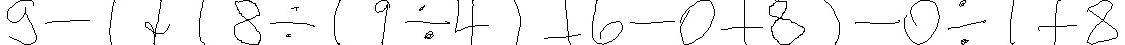

In [20]:
dataset = [x for x in split2dataset['train']]
for _ in range(10):
    sample = random.choice(dataset)
    img_paths = sample['img_paths']
    img = render_img(img_paths)
    print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
    display(img)

1 ============================================================
1 [-1] [1] 1


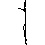

7+(9+(4/2-3*2+2)/(2/4)) [1, -1, 4, 4, 1, 13, 7, 9, 7, 13, 11, 9, 11, 16, 13, 13, 4, 19, 19, 16, 19, 19, 4] [7, 18, -1, 9, 11, -1, 4, 2, 2, 0, 3, 6, 2, 2, 2, -1, 2, -1, 2, 1, 4, -1, -1] 18


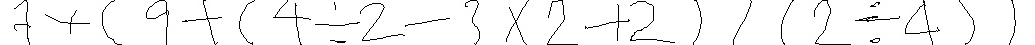

1/((4+0)*9)*(1*(2*7)-2) [1, 11, 8, 5, 5, 8, 5, 5, 1, 8, 8, -1, 20, 14, 20, 17, 17, 14, 17, 17, 11, 20, 20] [1, 1, -1, -1, 4, 4, 0, -1, 36, 9, -1, 12, -1, 1, 14, -1, 2, 14, 7, -1, 12, 2, -1] 12


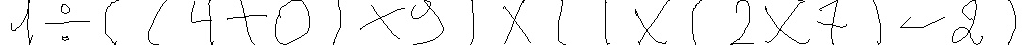

9/8 [1, -1, 1] [9, 2, 8] 2


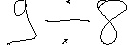

(3+6-0+2*2)/(1+5)-3/(2*8+8) [6, 2, 4, 2, 6, 4, 11, 8, 6, 8, 6, 17, 14, 14, 11, 14, 14, -1, 19, 17, 24, 22, 24, 22, 19, 24, 24] [-1, 3, 9, 6, 9, 0, 13, 2, 4, 2, -1, 3, -1, 1, 6, 5, -1, 2, 3, 1, -1, 2, 16, 8, 24, 8, -1] 2


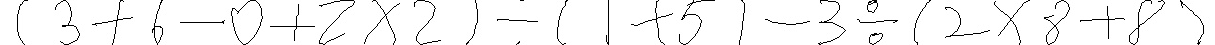

5*(0/9*(3*(4+(3+2)))/6) [1, -1, 20, 4, 6, 4, 20, 9, 9, 6, 12, 12, 9, 15, 15, 12, 15, 15, 12, 9, 1, 20, 20] [5, 0, -1, 0, 0, 9, 0, -1, 3, 27, -1, 4, 9, -1, 3, 5, 2, -1, -1, -1, 0, 6, -1] 0


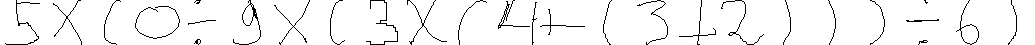

1-5 [1, -1, 1] [1, 0, 5] 0


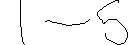

4-2 [1, -1, 1] [4, 2, 2] 2


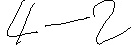

(8+4)*(6/(2*4)*(6-1-(1/7+4))) [2, 2, 5, 2, 2, -1, 14, 8, 14, 11, 11, 8, 11, 11, 5, 19, 17, 19, 17, 14, 24, 22, 24, 22, 19, 24, 24, 19, 14] [-1, 8, 12, 4, -1, 0, -1, 6, 1, -1, 2, 8, 4, -1, 0, -1, 6, 5, 1, 0, -1, 1, 1, 7, 5, 4, -1, -1, -1] 0


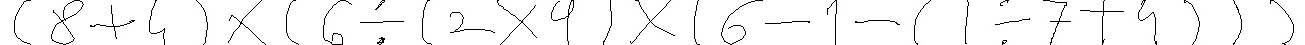

(7-9)/2/4*6+4+(8/7-1) [2, 2, 5, 2, 2, 7, 5, 9, 7, 11, 9, 13, 11, -1, 18, 16, 18, 16, 13, 18, 18] [-1, 7, 0, 9, -1, 0, 2, 0, 4, 0, 6, 4, 4, 5, -1, 8, 2, 7, 1, 1, -1] 5


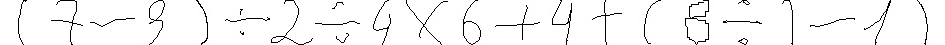

2 ============================================================
8/6*(1+9)+(2*6+3-5)-(2-7)-3+0*(5-3) [1, 3, 1, 9, 6, 6, 3, 6, 6, 19, 16, 12, 14, 12, 16, 14, 9, 16, 16, 25, 22, 22, 19, 22, 22, 27, 25, -1, 29, 27, 32, 32, 29, 32, 32] [8, 2, 6, 20, -1, 1, 10, 9, -1, 30, -1, 2, 12, 6, 15, 3, 10, 5, -1, 30, -1, 2, 0, 7, -1, 27, 3, 27, 0, 0, -1, 5, 2, 3, -1] 27


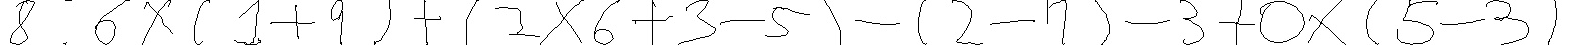

9*2*(3-(8+(4-0)))*(4+7*9)-(6-3+4) [1, 3, 1, 17, 6, 6, 3, 9, 9, 6, 12, 12, 9, 12, 12, 9, 6, 25, 20, 20, 17, 22, 20, 22, 20, -1, 30, 28, 30, 28, 25, 30, 30] [9, 18, 2, 0, -1, 3, 0, -1, 8, 12, -1, 4, 4, 0, -1, -1, -1, 0, -1, 4, 67, 7, 63, 9, -1, 0, -1, 6, 3, 3, 7, 4, -1] 0


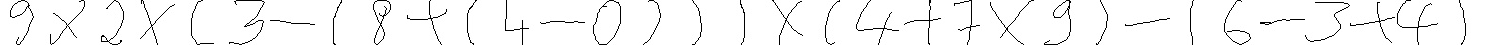

8/9+3/7 [1, 3, 1, -1, 5, 3, 5] [8, 1, 9, 2, 3, 1, 7] 2


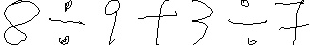

8*(0/(1+8)-3)+(1+0/3)*(9+6) [1, 13, 10, 4, 10, 7, 7, 4, 7, 7, 1, 10, 10, -1, 16, 16, 21, 18, 16, 18, 16, 13, 24, 24, 21, 24, 24] [8, 0, -1, 0, 0, -1, 1, 9, 8, -1, 0, 3, -1, 15, -1, 1, 1, 0, 0, 3, -1, 15, -1, 9, 15, 6, -1] 15


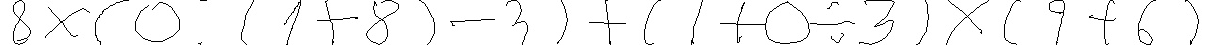

8*1-7 [1, 3, 1, -1, 3] [8, 8, 1, 1, 7] 1


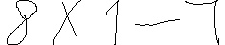

3*(4*7-4/((4+5)/2)) [1, -1, 6, 4, 6, 4, 1, 8, 6, 15, 12, 12, 15, 12, 12, 8, 15, 15, 6] [3, 81, -1, 4, 28, 7, 27, 4, 1, -1, -1, 4, 9, 5, -1, 5, 2, -1, -1] 81


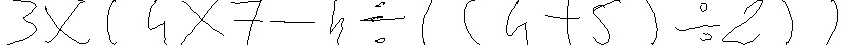

(5-5-6+3)*1 [6, 2, 4, 2, 6, 4, 9, 6, 6, -1, 9] [-1, 5, 0, 5, 0, 6, 3, 3, -1, 3, 1] 3


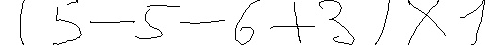

3-3*3-(8+7-9/(5*2/(0+6*5/3)*3)) [1, 5, 3, 1, 3, -1, 10, 8, 10, 8, 5, 12, 10, 27, 15, 17, 15, 27, 20, 20, 17, 22, 24, 22, 20, 24, 20, 12, 27, 27, 10] [3, 0, 3, 9, 3, 0, -1, 8, 15, 7, 12, 9, 3, -1, 5, 10, 2, 1, -1, 0, 10, 6, 30, 5, 10, 3, -1, 3, 3, -1, -1] 0


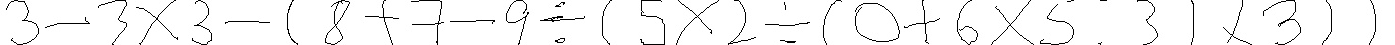

0/(5-0) [1, -1, 4, 4, 1, 4, 4] [0, 0, -1, 5, 5, 0, -1] 0


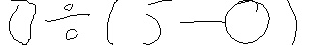

5*3+(3+(0+6)) [1, 3, 1, -1, 6, 6, 3, 9, 9, 6, 9, 9, 6] [5, 15, 3, 24, -1, 3, 9, -1, 0, 6, 6, -1, -1] 24


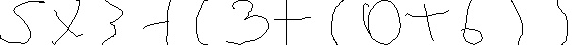

3 ============================================================
4-2*1+(5*6+4/(6+6-7))*5 [1, 5, 3, 1, 3, -1, 10, 8, 10, 8, 21, 12, 10, 17, 15, 17, 15, 12, 17, 17, 10, 5, 21] [4, 2, 2, 2, 1, 157, -1, 5, 30, 6, 31, 4, 1, -1, 6, 12, 6, 5, 7, -1, -1, 155, 5] 157


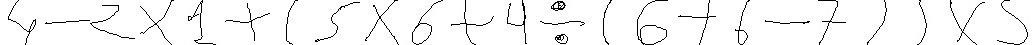

3*6*((8+1-6)*8)+2/4 [1, 3, 1, 15, 12, 9, 7, 9, 7, 12, 9, 9, 3, 12, 12, -1, 17, 15, 17] [3, 18, 6, 432, -1, -1, 8, 9, 1, 3, 6, -1, 24, 8, -1, 433, 2, 1, 4] 433


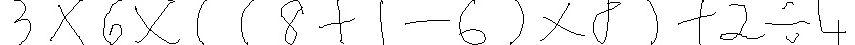

9*9*2/5 [1, 3, 1, 5, 3, -1, 5] [9, 81, 9, 162, 2, 33, 5] 33


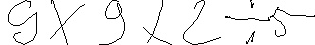

9*(1*9)+(5*(6*(6*9))*(2*1)-5*5) [1, 7, 4, 4, 1, 4, 4, -1, 26, 10, 20, 13, 13, 10, 16, 16, 13, 16, 16, 13, 26, 23, 23, 20, 23, 23, 7, 28, 26, 28, 26] [9, 81, -1, 1, 9, 9, -1, 3296, -1, 5, 1620, -1, 6, 324, -1, 6, 54, 9, -1, -1, 3240, -1, 2, 2, 1, -1, 3215, 5, 25, 5, -1] 3296


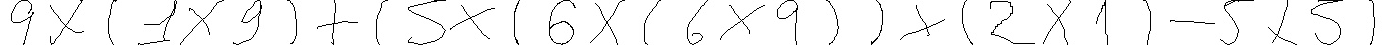

2*(4-2-1-(3+8)+(8*7+(7-4)+8)) [1, -1, 14, 4, 6, 4, 8, 6, 14, 11, 11, 8, 11, 11, 1, 25, 17, 19, 17, 25, 22, 22, 19, 22, 22, 14, 25, 25, 14] [2, 134, -1, 4, 2, 2, 1, 1, 0, -1, 3, 11, 8, -1, 67, -1, 8, 56, 7, 59, -1, 7, 3, 4, -1, 67, 8, -1, -1] 134


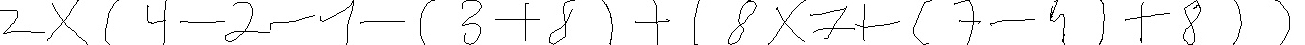

(4+9-((2+4)/3-(7*2+0)))*8 [4, 2, 4, 2, 23, 13, 8, 8, 11, 8, 8, 13, 11, 4, 18, 16, 18, 16, 13, 18, 18, 13, 4, -1, 23] [-1, 4, 13, 9, 13, -1, -1, 2, 6, 4, -1, 2, 3, 0, -1, 7, 14, 2, 14, 0, -1, -1, -1, 104, 8] 104


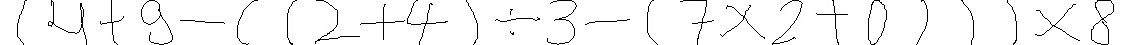

(5/(2/1)*8+0*4/(9*3*8))/(6/1+2*5) [10, 2, 8, 5, 5, 2, 5, 5, 10, 8, 23, 12, 14, 12, 10, 19, 17, 19, 17, 14, 19, 19, 10, -1, 28, 26, 28, 26, 23, 30, 28, 30, 28] [-1, 5, 3, -1, 2, 2, 1, -1, 24, 8, 24, 0, 0, 4, 0, -1, 9, 27, 3, 216, 8, -1, -1, 2, -1, 6, 6, 1, 16, 2, 10, 5, -1] 2


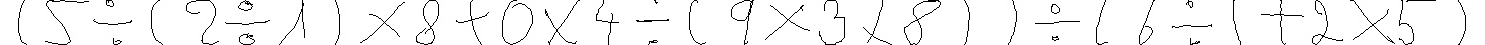

8/(7-5)*9/1*((5+2)*((5-3)*2))*6 [1, 7, 4, 4, 1, 4, 4, 9, 7, 11, 9, 29, 18, 15, 15, 18, 15, 15, 11, 25, 22, 22, 25, 22, 22, 18, 25, 25, 18, -1, 29] [8, 4, -1, 7, 2, 5, -1, 36, 9, 36, 1, 1008, -1, -1, 5, 7, 2, -1, 28, -1, -1, 5, 2, 3, -1, 4, 2, -1, -1, 6048, 6] 6048


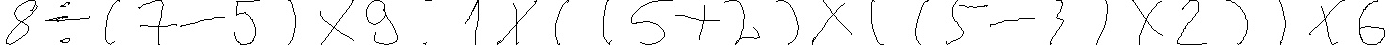

(5+7)*9 [2, 2, 5, 2, 2, -1, 5] [-1, 5, 12, 7, -1, 108, 9] 108


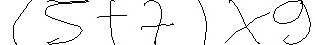

(8*(6/(1+2))-(7-3-1))*(4*(6+2)) [12, 2, 12, 5, 5, 2, 8, 8, 5, 8, 8, 5, 21, 17, 15, 17, 15, 12, 17, 17, 12, -1, 24, 24, 21, 27, 27, 24, 27, 27, 24] [-1, 8, 16, -1, 6, 2, -1, 1, 3, 2, -1, -1, 13, -1, 7, 4, 3, 3, 1, -1, -1, 416, -1, 4, 32, -1, 6, 8, 2, -1, -1] 416


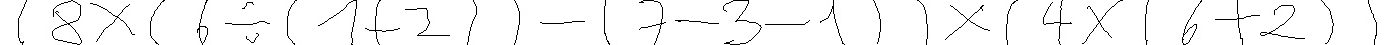

4 ============================================================
0*(2/(6-3)-6/5)*(2*4*2)-(5+((0-8*3)/2-8))*(5/(9*3)*6) [1, 15, 10, 4, 10, 7, 7, 4, 7, 7, 1, 12, 10, 12, 10, 23, 20, 18, 20, 18, 15, 20, 20, -1, 26, 26, 41, 37, 30, 30, 35, 32, 30, 32, 30, 37, 35, 26, 37, 37, 26, 23, 50, 44, 50, 47, 47, 44, 47, 47, 41, 50, 50] [0, 0, -1, 2, 1, -1, 6, 3, 3, -1, 0, 6, 2, 5, -1, 0, -1, 2, 8, 4, 16, 2, -1, 0, -1, 5, 5, -1, -1, 0, 0, 8, 24, 3, -1, 0, 2, 0, 8, -1, -1, 30, -1, 5, 1, -1, 9, 27, 3, -1, 6, 6, -1] 0


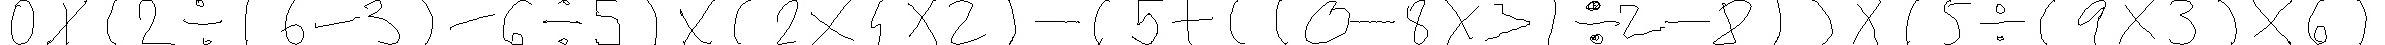

4/7/(5+2-2/(6*5))/(3+3/9)+(8-1)/8*6-0/(3+1) [1, 3, 1, 17, 8, 6, 8, 6, 3, 10, 8, 13, 13, 10, 13, 13, 8, 25, 20, 20, 17, 22, 20, 22, 20, 35, 28, 28, 31, 28, 28, 33, 31, 25, 33, -1, 37, 35, 40, 40, 37, 40, 40] [4, 1, 7, 1, -1, 5, 7, 2, 6, 2, 1, -1, 6, 30, 5, -1, -1, 1, -1, 3, 4, 3, 1, 9, -1, 7, -1, 8, 7, 1, -1, 1, 8, 6, 6, 7, 0, 0, -1, 3, 4, 1, -1] 7


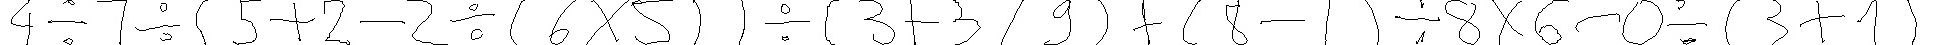

(7/8-5)*1/(2+8+(6+(4+9)))*((7-2)*(0+1))-(7-0) [4, 2, 4, 2, 7, 4, 4, 9, 7, 25, 14, 12, 14, 12, 9, 17, 17, 14, 20, 20, 17, 20, 20, 17, 14, 39, 32, 29, 29, 32, 29, 29, 25, 35, 35, 32, 35, 35, 32, -1, 42, 42, 39, 42, 42] [-1, 7, 1, 8, 0, 5, -1, 0, 1, 0, -1, 2, 10, 8, 29, -1, 6, 19, -1, 4, 13, 9, -1, -1, -1, 0, -1, -1, 7, 5, 2, -1, 5, -1, 0, 1, 1, -1, -1, 0, -1, 7, 7, 0, -1] 0


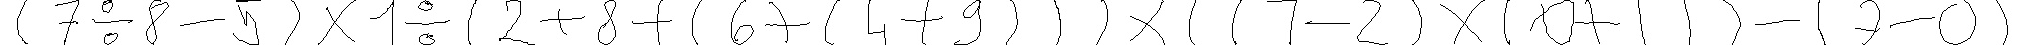

5-8-4-((7-(0-2)*4)/7-((3-0)/2+2*6+(3+(0+0))-(0-7))) [1, 3, 1, 5, 3, -1, 20, 9, 9, 18, 12, 12, 15, 12, 12, 9, 15, 9, 20, 18, 5, 43, 24, 24, 27, 24, 24, 29, 27, 33, 31, 29, 31, 43, 36, 36, 33, 39, 39, 36, 39, 39, 36, 20, 46, 46, 43, 46, 46, 43, 20] [5, 0, 8, 0, 4, 0, -1, -1, 7, 7, -1, 0, 0, 2, -1, 0, 4, -1, 1, 7, 0, -1, -1, 3, 3, 0, -1, 2, 2, 14, 2, 12, 6, 17, -1, 3, 3, -1, 0, 0, 0, -1, -1, 17, -1, 0, 0, 7, -1, -1, -1] 0


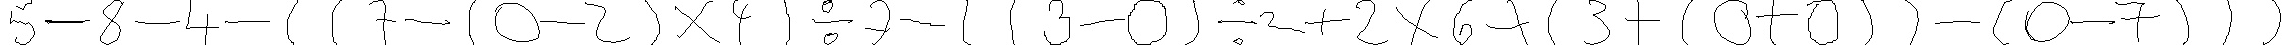

2/(5+(6/1+7/(8/7))-(4/(5*8)+(6+0)/(1-0))) [1, -1, 18, 4, 18, 9, 7, 9, 7, 4, 11, 9, 14, 14, 11, 14, 14, 9, 1, 27, 21, 27, 24, 24, 21, 24, 24, 18, 30, 30, 33, 30, 30, 27, 36, 36, 33, 36, 36, 27, 18] [2, 1, -1, 5, 15, -1, 6, 6, 1, 10, 7, 4, -1, 8, 2, 7, -1, -1, 8, -1, 4, 1, -1, 5, 40, 8, -1, 7, -1, 6, 6, 0, -1, 6, -1, 1, 1, 0, -1, -1, -1] 1


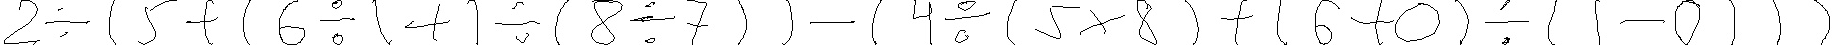

(2+9+(1/(6/9)-9))*((7-3)*0)/8*3-(0-((2+9)/4+7*9)) [4, 2, 4, 2, 17, 13, 7, 13, 10, 10, 7, 10, 10, 4, 13, 13, 4, 27, 24, 21, 21, 24, 21, 21, 17, 24, 24, 29, 27, 31, 29, -1, 34, 34, 31, 43, 38, 38, 41, 38, 38, 43, 41, 34, 45, 43, 45, 43, 34] [-1, 2, 11, 9, 11, -1, 1, 1, -1, 6, 1, 9, -1, 0, 9, -1, -1, 0, -1, -1, 7, 4, 3, -1, 0, 0, -1, 0, 8, 0, 3, 0, -1, 0, 0, -1, -1, 2, 11, 9, -1, 3, 4, 66, 7, 63, 9, -1, -1] 0


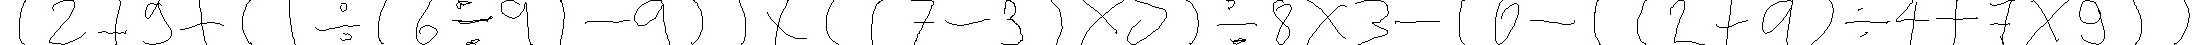

5*7/((3-2)/4+8)*((0-(9*9-2))*((8-3*2-(6*(1+4)-7))/(8*9))) [1, 3, 1, 15, 12, 7, 7, 10, 7, 7, 12, 10, 3, 12, 12, -1, 28, 19, 19, 28, 24, 22, 24, 22, 19, 24, 24, 19, 15, 49, 36, 32, 36, 34, 32, 34, 49, 45, 39, 45, 42, 42, 39, 42, 42, 36, 45, 45, 36, 28, 52, 52, 49, 52, 52, 49, 28] [5, 35, 7, 4, -1, -1, 3, 1, 2, -1, 1, 4, 9, 8, -1, 0, -1, -1, 0, 0, -1, 9, 81, 9, 79, 2, -1, -1, 0, -1, -1, 8, 2, 3, 6, 2, 0, -1, 6, 30, -1, 1, 5, 4, -1, 23, 7, -1, -1, 0, -1, 8, 72, 9, -1, -1, -1] 0


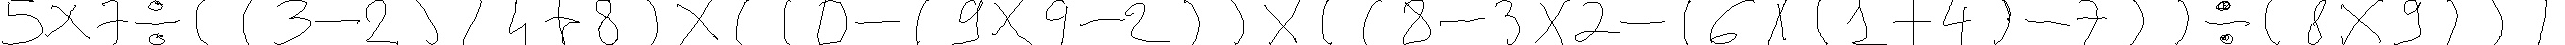

9-2+(7/3/(4-2+9)-1*(9+3)*0)+(0/1-(7*7-2-9*(1/3))) [1, 3, 1, 27, 16, 6, 8, 6, 16, 13, 11, 13, 11, 8, 13, 13, 3, 18, 24, 21, 21, 18, 21, 21, 16, 24, 16, -1, 32, 30, 32, 30, 27, 39, 35, 37, 35, 39, 37, 32, 41, 39, 44, 44, 41, 44, 44, 39, 32] [9, 7, 2, 8, -1, 7, 3, 3, 1, -1, 4, 2, 2, 11, 9, -1, 1, 1, 12, -1, 9, 12, 3, -1, 0, 0, -1, 8, -1, 0, 0, 1, 0, -1, 7, 49, 7, 47, 2, 38, 9, 9, -1, 1, 1, 3, -1, -1, -1] 8


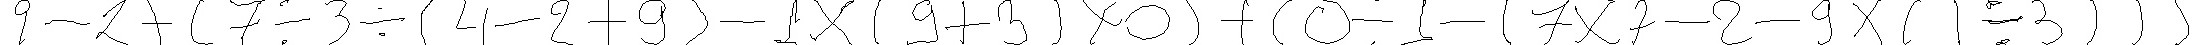

(0*(3/(3/2))+(0*4+(5+5)/(8+8-8)-(4-(3+3)-8*7)*(0/4+(5-3))))*6 [12, 2, 12, 5, 5, 2, 8, 8, 5, 8, 8, 5, 59, 31, 15, 17, 15, 31, 20, 20, 23, 20, 20, 17, 28, 26, 28, 26, 23, 28, 28, 12, 40, 34, 40, 37, 37, 34, 37, 37, 45, 42, 40, 42, 40, 31, 50, 48, 50, 48, 45, 53, 53, 50, 53, 53, 50, 31, 12, -1, 59] [-1, 0, 0, -1, 3, 2, -1, 3, 2, 2, -1, -1, 2, -1, 0, 0, 4, 2, -1, 5, 10, 5, -1, 2, -1, 8, 16, 8, 8, 8, -1, 2, -1, 4, 0, -1, 3, 6, 3, -1, 0, 8, 56, 7, -1, 0, -1, 0, 0, 4, 2, -1, 5, 2, 3, -1, -1, -1, -1, 12, 6] 12


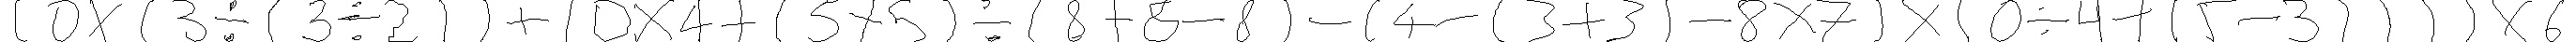

(1+0/(7/6+1*(2-1))/(2*9/(6/1)+3*8))/(1+5/8) [2, 2, 35, 4, 18, 9, 7, 9, 7, 4, 11, 9, 14, 14, 11, 14, 14, 9, 2, 29, 21, 23, 21, 29, 26, 26, 23, 26, 26, 18, 31, 29, 31, 29, 2, -1, 38, 38, 35, 40, 38, 40, 38] [-1, 1, 1, 0, 0, -1, 7, 2, 6, 3, 1, 1, -1, 2, 1, 1, -1, -1, 0, -1, 2, 18, 9, 3, -1, 6, 6, 1, -1, 27, 3, 24, 8, -1, -1, 1, -1, 1, 2, 5, 1, 8, -1] 1


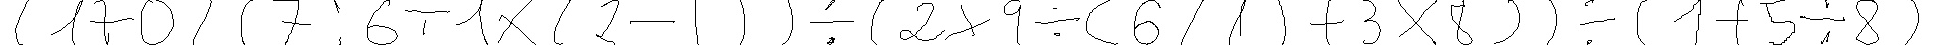

5 ============================================================
3-(7+4)/4+(8*7*(6+8)+(5/9*(9/(1*9/(9+1)*3))/(7/7)-(2+6+7))) [1, 9, 4, 4, 7, 4, 4, 1, 7, -1, 20, 12, 14, 12, 20, 17, 17, 14, 17, 17, 9, 49, 23, 25, 23, 43, 28, 28, 25, 39, 31, 33, 31, 39, 36, 36, 33, 36, 36, 28, 39, 39, 28, 49, 46, 46, 43, 46, 46, 20, 54, 52, 54, 52, 49, 54, 54, 49, 20] [3, 0, -1, 7, 11, 4, -1, 3, 4, 784, -1, 8, 56, 7, 784, -1, 6, 14, 8, -1, 784, -1, 5, 1, 9, 3, -1, 9, 3, -1, 1, 9, 9, 1, -1, 9, 10, 1, -1, 3, 3, -1, -1, 3, -1, 7, 1, 7, -1, 0, -1, 2, 8, 6, 15, 7, -1, -1, -1] 784


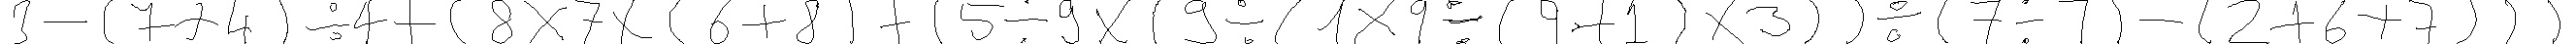

(5+2)*((5+2)*7+1*((6+6)/((3*7/5+5/(7*3*2-6))*(6/3)))) [2, 2, 5, 2, 2, -1, 14, 9, 9, 12, 9, 9, 14, 12, 5, 16, 14, 23, 20, 20, 23, 20, 20, 16, 44, 31, 27, 29, 27, 31, 29, 44, 33, 31, 40, 36, 38, 36, 40, 38, 33, 40, 40, 31, 23, 47, 47, 44, 47, 47, 44, 23, 14] [-1, 5, 7, 2, -1, 350, -1, -1, 5, 7, 2, -1, 49, 7, 50, 1, 1, -1, -1, 6, 12, 6, -1, 1, -1, -1, 3, 21, 7, 5, 5, 6, 5, 1, -1, 7, 21, 3, 42, 2, 36, 6, -1, -1, 12, -1, 6, 2, 3, -1, -1, -1, -1] 350


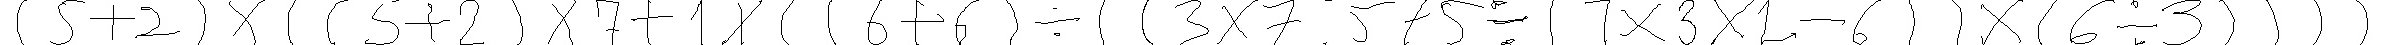

2/((4+6-2)*(2+(7*9-9))-((7-2+1)*(3*3)-(5-1+6*7))) [1, -1, 22, 7, 5, 7, 5, 10, 7, 7, 22, 13, 13, 10, 18, 16, 18, 16, 13, 18, 18, 13, 1, 37, 28, 26, 28, 26, 31, 28, 28, 37, 34, 34, 31, 34, 34, 22, 42, 40, 42, 40, 37, 44, 42, 44, 42, 37, 22] [2, 1, -1, -1, 4, 10, 6, 8, 2, -1, 448, -1, 2, 56, -1, 7, 63, 9, 54, 9, -1, -1, 440, -1, -1, 7, 5, 2, 6, 1, -1, 54, -1, 3, 9, 3, -1, 8, -1, 5, 4, 1, 46, 6, 42, 7, -1, -1, -1] 1


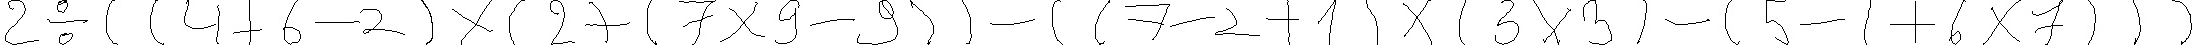

(2-9/4)/(7/(6*4*8)/5/7+9*(7-7))+(3+7*8)/(8/(0+1)-4/6*5) [2, 2, 7, 4, 2, 4, 2, 31, 22, 10, 18, 15, 13, 15, 13, 10, 15, 15, 20, 18, 22, 20, 7, 24, 22, 27, 27, 24, 27, 27, 22, -1, 34, 34, 39, 36, 34, 36, 34, 31, 48, 42, 48, 45, 45, 42, 45, 45, 39, 50, 52, 50, 48, 52, 48] [-1, 2, 0, 9, 3, 4, -1, 0, -1, 7, 1, -1, 6, 24, 4, 192, 8, -1, 1, 5, 1, 7, 1, 9, 0, -1, 7, 0, 7, -1, -1, 20, -1, 3, 59, 7, 56, 8, -1, 20, -1, 8, 8, -1, 0, 1, 1, -1, 3, 4, 1, 6, 5, 5, -1] 20


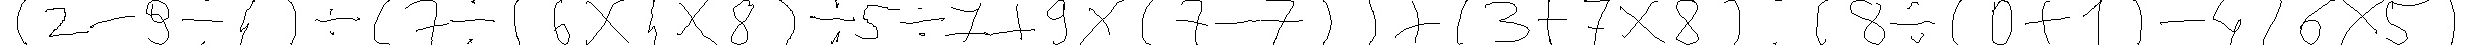

((7+4)*(4+8)+8+(2-3+3)+3*(3+7))*(4+(6+(3*8-1))) [22, 3, 3, 6, 3, 3, 12, 9, 9, 6, 9, 9, 14, 12, 22, 19, 17, 19, 17, 14, 19, 19, 31, 24, 22, 27, 27, 24, 27, 27, 22, -1, 34, 34, 31, 37, 37, 34, 42, 40, 42, 40, 37, 42, 42, 37, 34] [-1, -1, 7, 11, 4, -1, 132, -1, 4, 12, 8, -1, 140, 8, 143, -1, 2, 0, 3, 3, 3, -1, 173, 3, 30, -1, 3, 10, 7, -1, -1, 5709, -1, 4, 33, -1, 6, 29, -1, 3, 24, 8, 23, 1, -1, -1, -1] 5709


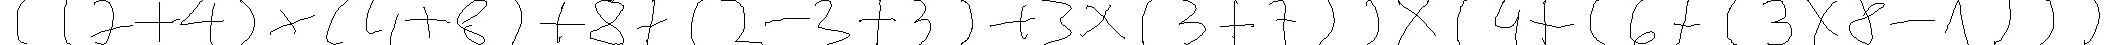

2*9+(9+(8+2-8)-(1*(6-4)-2))+((0+4)*((3-0)*7)-(7/3+7)) [1, 3, 1, 27, 14, 6, 14, 11, 9, 11, 9, 6, 11, 11, 3, 23, 17, 23, 20, 20, 17, 20, 20, 14, 23, 23, 14, -1, 44, 31, 31, 34, 31, 31, 44, 41, 38, 38, 41, 38, 38, 34, 41, 41, 27, 49, 47, 49, 47, 44, 49, 49, 44] [2, 18, 9, 29, -1, 9, 11, -1, 8, 10, 2, 2, 8, -1, 11, -1, 1, 2, -1, 6, 2, 4, -1, 0, 2, -1, -1, 103, -1, -1, 0, 4, 4, -1, 84, -1, -1, 3, 3, 0, -1, 21, 7, -1, 74, -1, 7, 3, 3, 10, 7, -1, -1] 103


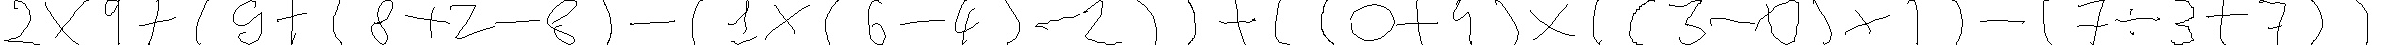

2-1+4-(0-(2-1+0)-(2-9))*((7+8)*(8+3)-5*6*(6+1))-0*9*1/4 [1, 3, 1, 5, 3, 47, 16, 8, 16, 13, 11, 13, 11, 8, 13, 13, 23, 19, 19, 16, 19, 19, 16, 5, 36, 27, 27, 30, 27, 27, 36, 33, 33, 30, 33, 33, 23, 38, 40, 38, 36, 43, 43, 40, 43, 43, 36, -1, 49, 51, 49, 53, 51, 47, 53] [2, 1, 1, 5, 4, 5, -1, 0, 0, -1, 2, 1, 1, 1, 0, -1, 0, -1, 2, 0, 9, -1, -1, 0, -1, -1, 7, 15, 8, -1, 165, -1, 8, 11, 3, -1, 0, 5, 30, 6, 210, -1, 6, 7, 1, -1, -1, 5, 0, 0, 9, 0, 1, 0, 4] 5


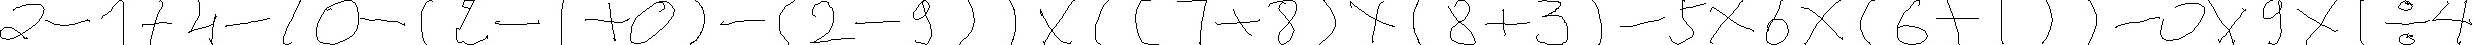

(6+9)*(7-4)*3+((7+6)/6+6/4)*(7-5)*7*(1*6) [2, 2, 5, 2, 2, 11, 8, 8, 5, 8, 8, 13, 11, -1, 22, 17, 17, 20, 17, 17, 22, 20, 27, 24, 22, 24, 22, 33, 30, 30, 27, 30, 30, 35, 33, 13, 38, 38, 35, 38, 38] [-1, 6, 15, 9, -1, 45, -1, 7, 3, 4, -1, 135, 3, 555, -1, -1, 7, 13, 6, -1, 3, 6, 5, 6, 2, 4, -1, 10, -1, 7, 2, 5, -1, 70, 7, 420, -1, 1, 6, 6, -1] 555


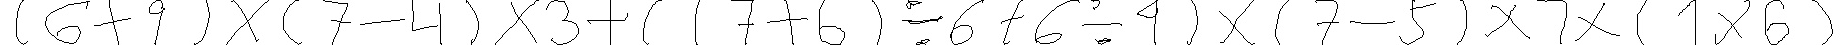

(7/6*2-(7+3)*(6-0-4))*(9*(6/1*3*(6/1)))+6 [6, 2, 4, 2, 6, 4, 21, 9, 9, 12, 9, 9, 6, 17, 15, 17, 15, 12, 17, 17, 6, 39, 24, 24, 21, 31, 27, 29, 27, 31, 29, 24, 34, 34, 31, 34, 34, 31, 24, -1, 39] [-1, 7, 2, 6, 4, 2, 0, -1, 7, 10, 3, -1, 20, -1, 6, 6, 0, 2, 4, -1, -1, 0, -1, 9, 972, -1, 6, 6, 1, 18, 3, 108, -1, 6, 6, 1, -1, -1, -1, 6, 6] 6


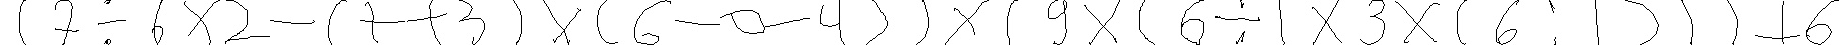

1*8-(2-8)-(0-5+7-9/(2+9*(9+6)-(2/8+(7-0))-9)) [1, 3, 1, 9, 6, 6, 3, 6, 6, -1, 16, 12, 14, 12, 16, 14, 9, 18, 16, 41, 21, 29, 23, 21, 26, 26, 23, 26, 26, 41, 34, 32, 34, 32, 29, 37, 37, 34, 37, 37, 34, 18, 41, 41, 16] [1, 8, 8, 8, -1, 2, 0, 8, -1, 2, -1, 0, 0, 5, 7, 7, 6, 9, 1, -1, 2, 137, 9, 135, -1, 9, 15, 6, -1, 129, -1, 2, 1, 8, 8, -1, 7, 7, 0, -1, -1, 120, 9, -1, -1] 2


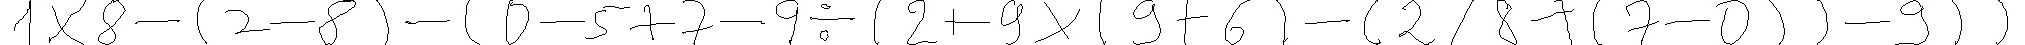

In [21]:
for i in range(1, 6):
    print(i, '='*60)
    dataset = [x for x in split2dataset['test'] if x['eval'] == i]
    for _ in range(10):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
        display(img)

# 4. Generate fewshot dataset

In [22]:
fewshot_concepts = list('abcde')
op2precedence.update({'a': 2, 'b': 2, 'c': 3, 'd': 3, 'e': 4})
op2arity.update({'a': 2, 'b': 2, 'c': 2, 'd': 2, 'e': 2})
functions = [lambda x,y: max(x, y), lambda x,y: min(x, y), lambda x,y: math.ceil((x+y)/2), 
             lambda x,y: max(0, (x*y)-(x+y)), lambda x,y: x**y if y < 10 else None]
programs = [Program(f) for f in functions]
SYM2PROG.update(dict(zip(fewshot_concepts, functions)))

In [23]:
random.seed(12306)
max_op = 20
max_train_op = 10

for i, fs in enumerate(fewshot_concepts):
    if i != 3:
        continue
    train_exprs = []
    val_exprs = []
    test_exprs = []
    n_test = 10
    n_val = 10
    
    op_list = ['+', '-', '*', '/', fs]
    
    # generate symbolic expression
    for n_op in range(max_op + 1):
        n_train = 20 if n_op == 1 else 10
        if n_op > max_train_op:
            n_train = 0
        expressions = generate_expression(n_op, 1000, max_value=max_value_train)
        expressions = [x for x in expressions if fs in x[0]]

        if n_train > 0:
            train_exprs.append(expressions[:n_train])
        val_exprs.append(expressions[:min(n_val, n_train)] + expressions[n_train:n_train+n_val])
        test_exprs.append(expressions[:n_train + n_test])

        expressions = generate_expression(n_op, 1000, 
                              min_value=max_value_train+1, max_value=max_value_test, non_zero_res=True)
        expressions = [x for x in expressions if fs in x[0]]
        val_exprs[-1].extend(expressions[:n_val])
        test_exprs[-1].extend(expressions[:n_test])

        print(n_op, len(train_exprs[-1]) if n_train > 0 else 0, len(val_exprs[-1]), len(test_exprs[-1]))

    split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
    print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])
    
    # generate handwritten expression
    split2dataset = {}
    for split in splits:
        sym_set = split2sym[split]
        exprs = split2exprs[split]
        dataset = []
        idx = 0
        for n_op, expr_list in enumerate(exprs):
            n_instance = 1
            if split == 'val':
                n_instance *= 0.1
            for e in expr_list:
                for _ in range(int(math.ceil(n_instance))):
                    img_paths = generate_img_paths(e[0], sym_set)
                    sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                          'expr': e[0], 'head': e[1], 'res': e[2], 'res_all': e[3]}
                    idx += 1
                    dataset.append(sample)
        split2dataset[split] = dataset
        print(split, len(dataset))
    
    # generate evaluation flag
    train_exprs = {x['expr'] for x in split2dataset['train']}
    max_len_train = max([len(x) for x in train_exprs])
    print(max_len_train)
    for split in ['val', 'test']:
        dataset = split2dataset[split]
        for sample in dataset:
            expr = sample['expr']
            if expr in train_exprs:
                evaluation = 1
            elif len(expr) <= max_len_train:
                max_value = max([x for x in sample['res_all'] if x is not None])
                if max_value <= max_value_train:
                    evaluation = 2
                else:
                    evaluation = 3
            else:
                max_value = max([x for x in sample['res_all'] if x is not None])
                if max_value <= max_value_train:
                    evaluation = 4
                else:
                    evaluation = 5
            sample['eval'] = evaluation
    
    # save
    for split in splits:
        json.dump(split2dataset[split], open('fewshot_%d_expr_%s.json'%(i, split), 'w'))

0 0 0 0


AttributeError: 'function' object has no attribute 'likelihood'

In [ ]:
counts = sorted(Counter([x['eval'] for x in split2dataset['test']]).items())
total_count = sum([c for _, c in counts])
counts = [(k, round(v/total_count*100, 2)) for k, v in counts]
print(counts)
print(list({x['expr'] for x in split2dataset['test'] if x['eval'] == 3})[:10])
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
print(max_len_train)

# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    all_symbols = [(x, y) for sample in dataset for x, y in zip(sample['img_paths'], sample['expr'])]
    print(sorted(Counter([x[1] for x in all_symbols]).items()))
    print(sorted(Counter([x[1] for x in set(all_symbols)]).items()))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
        display(img)